100%|██████████| 100/100 [00:57<00:00,  1.74it/s]

Execution: 57.60961127281189 seconds


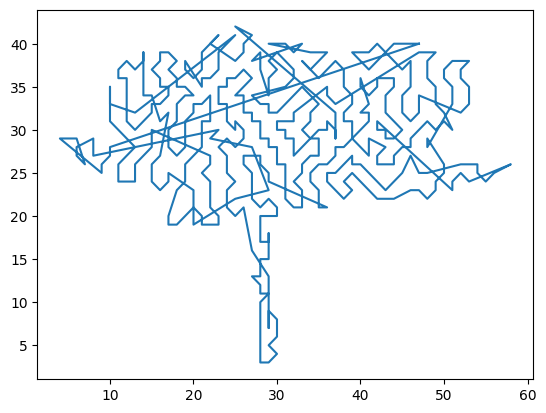

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import random
from tqdm import tqdm
import time

class DitheringMaker:
    '''
    Performs dithering on an image using the classical Floyd-Steinberg dithering algorithm. The
    dithering isn't applied to the last row or the edge columns. Instead, the last row and edge
    columns are made all white as this will later not add any vertices when we extract vertices
    from the dithering.

    Members
    -------
    dithering : Numpy array of Int of Shape(n_rows, nCol)
        The array holding the dithering of the image. Note that the last row and edge columns will
        always be converted to white (i.e. 255).

    row_disp : Numpy array of Int of shape (2, 3)
        The row offsets to apply the diffusions to.

    col_disp : Numpy array of Int of shape (2, 3)
        The column offsets to apply the diffusions to.

    diffusion_prop : Numpy array of Float of shape (2, 3)
        The Floyd-Steinberg coefficients for diffusing the error in the
        dithering.
    '''

    def __init__(self):
        '''
        Initialize the dithering to None as we haven't performed any yet.

        The displacement of indices and the diffusion coefficients are for the classic
        Floyd-Steinberg dithering algorithm.
        '''

        self.dithering = None

        self.row_disp = np.full((2, 3), np.arange(0, 2)[:, np.newaxis], dtype = 'int')
        self.col_disp = np.full((2, 3), np.arange(-1, 2), dtype = 'int')
        self.diffusion_prop = np.array([[0, 0, 7],
                                        [3, 5, 1]]) / 16

    def make_dithering(self, pixels, cutoff = 255 / 2):
        '''
        Apply the classic Floyd-Steinberg dithering algorithm, but for simplicity
        we just make the edge columns and the last row all white (which will give
        us no vertices when we later extract vertices).

        Parameters
        ----------
        pixels : Numpy array of Int of shape (n_rows, n_cols)
            The gray scale pixels to apply the dithering to.

        cutoff : Float
            The cut off for making a dithering pixel either 0 or 255.

        Returns
        -------
        Numpy array of Int of Shape (n_rows, n_cols)
            The final dithering; each pixel is either 0 or 255 (black or white).
        '''

        # We use Floyd-Steinberg dithering. Error diffusion is
        # _     x     7/16
        # 3/16  5/16  1/16

        self.dithering = pixels.copy().astype('float')

        n_rows, n_cols = pixels.shape

        # Initialize the first column to be white.

        self.dithering[:][0] = 255

        # Iterate over each row, applying the dithering and diffusing the error.

        for row in range(n_rows - 1):
            for col in range(1, n_cols - 1):

                dither, error = self.get_dither(row, col, cutoff)
                self.dithering[row, col] = dither
                self.diffuse_error(error, row, col)

        # Make the last column and the last row all white.

        self.dithering[:, -1] = 255
        self.dithering[-1, :] = 255

        # Convert dithering to Numpy array of Int.

        self.dithering = self.dithering.astype('int')

        return self.dithering

    def get_dither(self, row, col, cutoff):
        '''
        Turn (dithered) pixel into either 0 or 255 using cutoff.

        Parameters
        ----------
        row : Int
            Index of pixel row.

        col : Int
            Index of pixel column.

        cutoff : Float
            The cutoff value to use for converting dithering value to either 0 or 255
            (black or white).

        Returns
        -------
        dither : Float
            Floating point value that is either 0.0 or 255.0 (black or white).

        error : Float
            The error in applying the conversion, this needs to be diffused to other pixels
            according to the dithering algorithm.
        '''

        pixel = self.dithering[row][col]

        if pixel < cutoff:
            dither = 0.0
        else:
            dither = 255.0

        error = pixel - dither

        return dither, error

    def diffuse_error(self, error, row, col):
        '''
        Diffuse the error from a (dithered) pixel conversion to black or white. The diffusion
        is applied to the neighbors of the pixel at position [row, col] according to the
        Floyd-Steinberg algorithm.

        Parameters
        ----------
        error : Float
            The size of error to diffuse to other pixels.

        row : Int
            The row index of where the conversion took place.

        col : Int
            The column index of where the conversion took place.
        '''

        self.dithering[row + self.row_disp, col + self.col_disp] += error * self.diffusion_prop


def get_vertices(dithering):
    '''
    Get the vertices from a black and white image, not grayscale (in particular a dithered image).
    Every black pixel (value 0.0) gives a vertex.

    Parameters
    ----------
    dithering : Numpy array of shape (n_rows, n_cols)
        The array of pixels for the dithered image.

    Returns
    -------
    Numpy array of shape (nVertices, 2)
        The xy-coordinates of the vertices.
    '''

    n_rows, n_cols = dithering.shape

    # Each black pixel gives a vertex.
    keep_pixel_mask = (dithering == 0)

    # Get the row and column indices of the vertices.

    rows = np.full(dithering.shape, np.arange(n_rows)[:, np.newaxis]).reshape(-1)
    cols = np.full(dithering.shape, np.arange(n_cols)).reshape(-1)

    rows = rows[keep_pixel_mask.reshape(-1)]
    cols = cols[keep_pixel_mask.reshape(-1)]

    # Get the xy-coordinate of the vertices. Make sure to transform row index so
    # that the last row has y value 0.

    vertices = np.stack([cols, n_rows - rows], axis = -1)

    return vertices


def getPixels(image, ds=1):
    '''
    Get the pixels as a numpy array from a PIL image.
    We can take the mean of each ds x ds subsquare as an array element inorder to down-size
    the size of the image if we want to.

    Parameters
    ----------
    image : PIL Image
        The PIL image to convert.

    ds : Int
        We take the mean of each ds x ds sub-square for a single element of our array.

    Returns
    -------
    2d Numpy array of floats
        The converted values of the pixels in the image. We use mean because we
        possibly took a mean over sub-squares.
    '''

    imwidth, imheight = image.size
    pixels = list(image.getdata())
    pixels = np.array(pixels).reshape((imheight, imwidth))

    pixels = [[pixels[i:i + ds, j:j + ds].mean() for j in np.arange(0, imwidth, ds)]
              for i in np.arange(0, imheight, ds)]
    pixels = np.array(pixels)
    return pixels


class ACO:
    def __init__(self, dots, max_iter=None, ants=None, q=None, alpha=None, beta=None, decay=None):
        self.dots = dots
        self.ants = len(dots) if not ants else ants
        self.q = 1 if not q else q
        self.alpha = 1 if not alpha else alpha
        self.beta = 1 if not beta else beta
        self.decay = 0.5 if not decay else decay
        self.pheromones = np.ones((len(self.dots), len(self.dots))) / len(self.dots)
        self.distance_matrix = np.array([[self.calculate_distance(i, j) for j in range(len(dots))] for i in range(len(dots))])
        self.reverse_distance = 1 / (self.distance_matrix + 0.001)
        self.max_iter = len(dots) if not max_iter else max_iter
        self.best_path = None
        self.best_path_length = float('inf')
        self.paths = np.zeros((self.ants, len(dots)), dtype=int)

    def calculate_distance(self, i, j):
        """
        Function to calculate Euclidian distance between dots
        :param i: Int
            Index of first dot
        :param j: Int
            Index of second dot
        :return: FLoat
            Distance between dots
        """
        return ((self.dots[i][0] - self.dots[j][0]) ** 2 + (self.dots[i][1] - self.dots[j][1]) ** 2) ** 0.5

    def solveTSP(self, verbose=False):
        for i in tqdm(range(self.max_iter)):
            probabilities = (self.pheromones ** self.alpha) * (self.reverse_distance ** self.beta)
            for j in range(self.ants):
                path = [random.randint(0, len(self.dots) - 1)]
                remaining_dots = set(range(0, len(self.dots)))
                remaining_dots.remove(path[0])
                current = path[0]
                while remaining_dots:
                    possible_dots = list(remaining_dots)
                    probs = probabilities[current][possible_dots]
                    probs = probs / sum(probs)
                    chosen = np.random.choice(possible_dots, p=probs)
                    remaining_dots.remove(chosen)
                    path.append(chosen)
                    current = chosen
                self.paths[j] = np.array(path)
            lengths = [self.calculate_path_length(path) for path in self.paths]
            for j in range(len(self.paths)):
                self.pheromones[self.paths[j][len(self.paths[j])-1]][self.paths[j][0]] += self.q / lengths[j]
                for k in range(len(self.paths[j]) - 1):
                    self.pheromones[self.paths[j][k]][self.paths[j][k + 1]] += self.q / lengths[j]
            current_best_path = np.argmin(lengths)
            if lengths[current_best_path] < self.best_path_length:
                self.best_path_length = lengths[current_best_path]
                self.best_path = self.paths[current_best_path]
            self.pheromones *= self.decay
            if verbose:
                print('Iteration', i, 'best path:', self.best_path_length,
                      'current best:', lengths[current_best_path])
        return self.best_path

    def calculate_path_length(self, path):
        return sum([self.distance_matrix[path[i]][path[i+1]] for i in range(len(path)-1)])

    def plot_path(self, path):
        """
        Function to plot the path
        :param path: Array of Int
            Path
        """
        x = []
        y = []
        for dot in path:
            x.append(self.dots[dot][0])
            y.append(self.dots[dot][1])
        x.append(x[0])
        y.append(y[0])
        plt.plot(x, y)
        plt.show()


if __name__ == '__main__':
    # Open the test image
    image = Image.open('flower.png').convert('L')
    # For now the function from the internet to get pixels is used
    pixel_image = getPixels(image, ds=5)
    # For now the function from the internet to make dithering is used
    ditherer = DitheringMaker()
    dithered_image = ditherer.make_dithering(pixel_image)
    vertices = get_vertices(dithered_image)
    # Perform Ant Colony Optimization on given dots
    aco_solver = ACO(vertices, ants=10, max_iter=100, beta=3, alpha=2, q=0.8)
    start = time.time()
    best_path = aco_solver.solveTSP()
    # Draw the result
    end = time.time()
    print('Execution:', end-start, 'seconds')
    aco_solver.plot_path(best_path)
